   # Introduction

The objective of this project is to study and understand the impact of different variables on the movements of crude oil spot prices. We hope to then build a model that is capable of predicting oil price movements in the near and medium term. 

Or main source of data is is the Energy Information Agency's API, which provides a large variety of datasets related to the Eenergy industry. From this source, we will get the actual spot price data over time, as well as time series data for following variables: 

Weekly inventory levels: 

The amount of crude oil in storage in the US for a given week. This basically serves as our measure of supply. 

U.S. Weekly product supplied:

Measures the disappearance of petroleum products from primary sources; approximately represents consumption of petroleum products.

We will also incorporate the Dow Jones Industrial Average in order to evaluate the relationship between crude oil prices and the performance of the broader market.



In [1]:
from datashop import *
from data_functions import *

import pprint as pp

import plotly.offline as pyo
import plotly.graph_objs as go
from pmdarima.arima import auto_arima

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.stattools import adfuller,kpss,coint,bds,q_stat,grangercausalitytests,levinson_durbin

# Capture 
eia_dict = {        
        'PET.RWTC.D':['DailyPrice','241335','%Y%m%d'],
        'PET.WTTSTUS1.W':['WeeklyStocks','235081','%Y%m%d'],
        'PET.WRPUPUS2.W':['ProductSupplied','401676','%Y%m%d']
    }

# Price

Lets get the price data from the EIA, and study it by itself. We will try to find patterns in like like seasonality and swhwh012901I 02:30pm

In [3]:
desc = 'Daily Price'
price = EIA_Series('PET.RWTC.D',desc='Desc')

In [4]:
price.frame.columns = ['DailyPrice','date_only']
dailyp_feat = Feature(price['DailyPrice'])

Possibly Categorical?                     No
Length                                  4992
Values                                  4992
Missing                              0(0.0)%
Unique                                  3763
Earliest Point           2001-01-02 00:00:00
Latest Point             2020-11-03 00:00:00
dtype: object

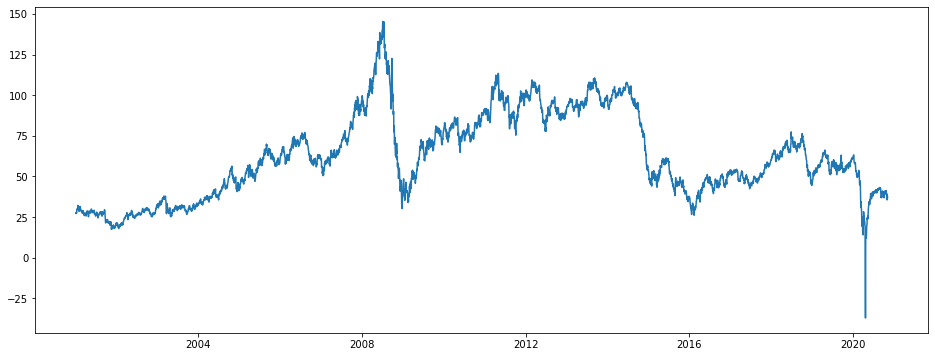

In [6]:
dailyp_feat.show_report()